In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import integrate
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.titlesize'] = 13

# 1.Coupled Oscillators

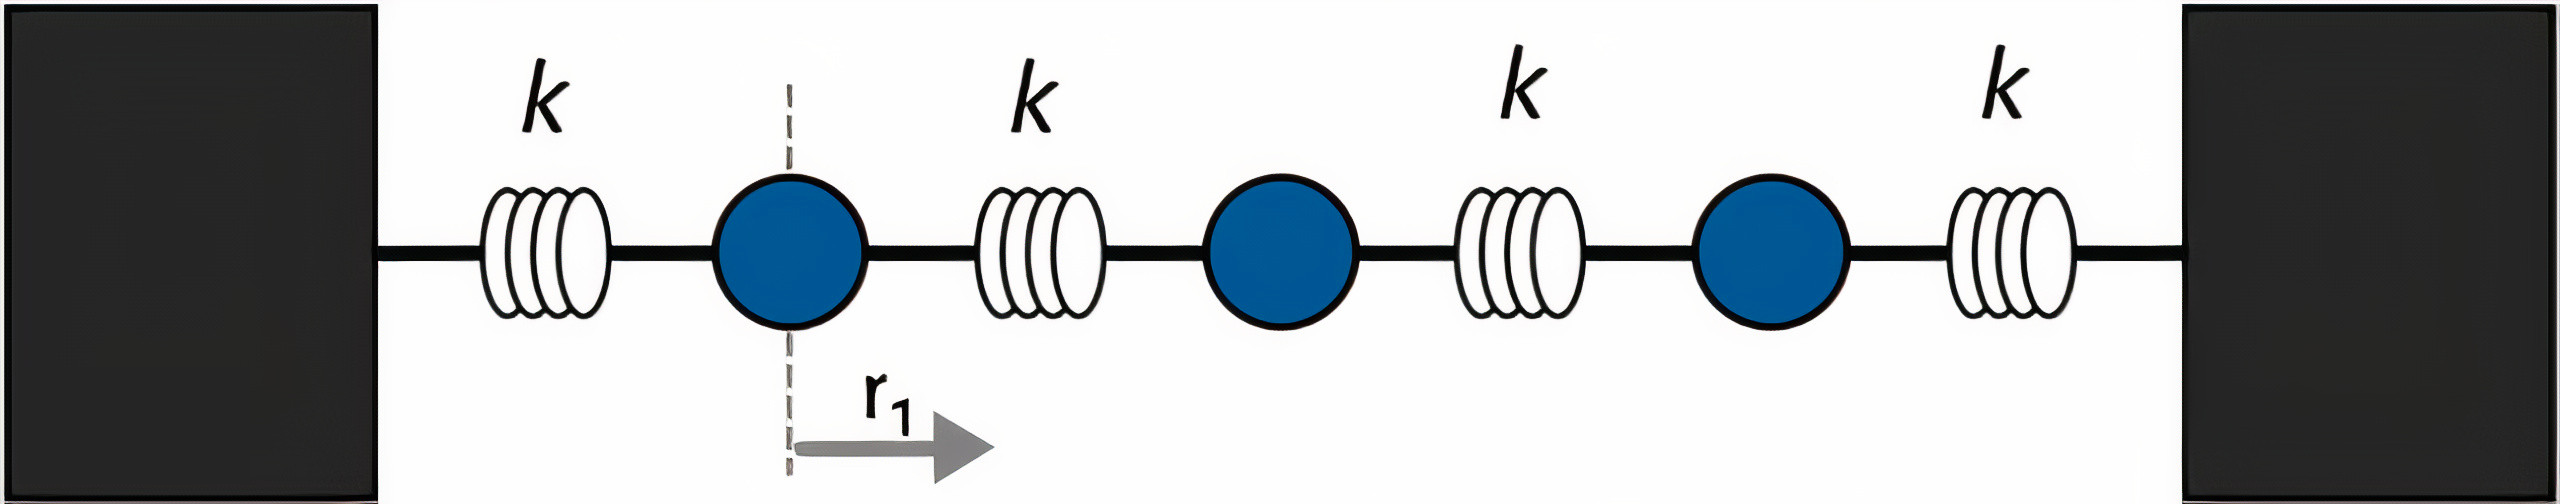

In [2]:
from PIL import Image
Image.open(r'./images/coupledOsc1.png')

$$ m\ddot{r}_1 = -k(r_1) -k(r_1-r_2) $$
$$ m\ddot{r}_2 = -k(r_2-r_1) -k(r_2-r_3) $$
$$ m\ddot{r}_3 = -k(r_3-r_2) -k(r_3) $$

Which can be written as
$$
\begin{pmatrix}\ddot{r}_1\\\ddot{r}_2\\\ddot{r}_3\end{pmatrix}=-\frac{k}{m}
\begin{pmatrix}2&-1&0\\-1&2&-1\\0&-1&2\end{pmatrix}
\begin{pmatrix}r_1\\ r_2\\ r_3\end{pmatrix}
$$
where '$r$' represents the deviation from the equilibrium position, as shown in the above figure.

## First: Solving the coupled differential equations numerically

In [3]:
def f(t,r,k,m):
    coords=r[0:3]
    v=r[3:6]
    acc=-k/m* np.array([
        2*coords[0]-coords[1],
        -1*coords[0]+2*coords[1]-1*coords[2],
        -1*coords[1]+2*coords[2]
    ])
    return [v[0],v[1],v[2],acc[0],acc[1],acc[2]]

In [4]:
t0=0
tFinal=100
k=1
m=1
r0=0.5 * (2*np.random.rand(6)-1) #random starting conditions, array of 6 numbers between -0.5 and 0.5
sol=integrate.solve_ivp(f,[t0,tFinal],r0,method='RK45',t_eval=np.linspace(t0,tFinal,1001),args=(k,m))

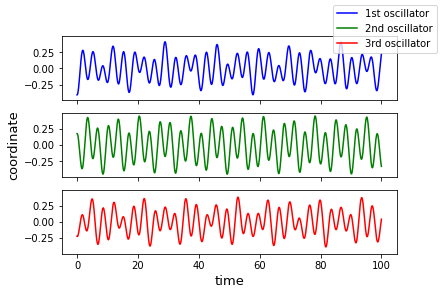

In [5]:
fig, axs = plt.subplots(3, sharex=True, sharey=True)
axs[0].plot(sol.t,sol.y[0],color='blue',label='1st oscillator')
axs[1].plot(sol.t,sol.y[1],color='green',label='2nd oscillator')
axs[1].set_ylabel('coordinate')
axs[2].plot(sol.t,sol.y[2],color='red',label='3rd oscillator')
axs[2].set_xlabel('time')
fig.legend()

## Solving it as an eigenvalue problem

We will solve it as an eigenvalue problem to be able to calculate the eigenfrequencies, and generate a model function that's able to intrpolate the data.

If we were able to convert the matrix we have into a diagonal matrix, or into a scalar, this will make our life easier.

In other words, converting this:
$$
\begin{pmatrix}\ddot{r}_1\\\ddot{r}_2\\\ddot{r}_3\end{pmatrix}=-\frac{k}{m}
\begin{pmatrix}2&-1&0\\-1&2&-1\\0&-1&2\end{pmatrix}
\begin{pmatrix}r_1\\ r_2\\ r_3\end{pmatrix}
$$
into this:
$$
\begin{pmatrix}\ddot{q}_1\\\ddot{q}_2\\\ddot{q}_3\end{pmatrix}=-\frac{k}{m}
\lambda
\begin{pmatrix}q_1\\ q_2\\ q_3\end{pmatrix}
$$
therefore the solution analytically would be a harmonic oscillators with frequecy:
$\omega = \sqrt{\frac{k}{m}\lambda}$ 

which means we have to find a unitary matrix $\underline{u}$ with $\underline{u}^{-1}\underline{u} = \underline{u}\,\underline{u}^{-1} = 1$ and as we know $\lambda=\underline{u}^{-1}\underline{A}\,\underline{u} $

###  Calculating the eigenvalues

* 1) Creating our own method

$$|A- \lambda I|=0$$

In [6]:
A = np.array([[2,-1,0],[-1,2,-1],[0,-1,2]])

In [7]:
def det3Dim(A):
    first=A[0,0]*( A[1,1]*A[2,2]-A[1,2]*A[2,1])
    second=-A[0,1]*(A[1,0]*A[2,2]-A[1,2]*A[2,0])
    third=A[0,2]*(A[1,0]*A[2,1]-A[1,1]*A[2,0])
    return first+second+third

In [8]:
def characteristic(x):
    return det3Dim(A-np.identity(3)*x)
    

In [9]:
def findEigen(characteristic,xMin,h):
    #characteristic: represents the |A-lamda*I|=0
    #xMin: our starting value.
    #h: step size
    numberOfRoots=3
    errorAccepted=0.000000001
    assumedValue=xMin+h
    step=h
    signFirst=np.sign(characteristic(xMin))
    signSecond=np.sign(characteristic(assumedValue))
    roots=[]
    while len(roots)<numberOfRoots:
        while step>errorAccepted:
            while signFirst-signSecond==0:
                assumedValue=assumedValue+step
                signFirst=signSecond
                signSecond=np.sign(characteristic(assumedValue))
                
            #if a sign change occured, then decrease the step size
            #and go back until u achieve the accepted error.
            assumedValue=assumedValue-step
            signFirst=np.sign(characteristic(assumedValue-step))
            signSecond=np.sign(characteristic(assumedValue))
            step=step*0.1
        #store the root.
        roots.append(assumedValue)
        #reset step.
        step=h
        #find the next root.
        assumedValue=assumedValue+step
        signFirst=np.sign(characteristic(assumedValue))
        signSecond=np.sign(characteristic(assumedValue+step))
    return roots            
            

In [10]:
findEigen(characteristic,-100,0.01)

[0.5857864370142498, 1.9999999990142507, 3.41421356201422]

* 2) Using np method

In [11]:
np.linalg.eigvals(A)
#the same output as our created function

array([3.41421356, 2.        , 0.58578644])

### Analyzing the eignensystem

After calculating the eingenvalues, this leads us to the eigenfrequencies:  $\omega = \sqrt{\frac{k}{m}\lambda}$
$$
\omega_1 = \sqrt{\frac{k}{m}}\sqrt{3.41421356}, \quad \omega_2 = \sqrt{\frac{k}{m}}\sqrt{2}, \quad \omega_3 = \sqrt{\frac{k}{m}}\sqrt{0.58578644}$$

In [12]:
# calcuting the eingvecotrs.
np.linalg.eig(A) #this shows us the whole eigen system(eigenvalues & eigenvectors)

(array([3.41421356, 2.        , 0.58578644]),
 array([[-5.00000000e-01, -7.07106781e-01,  5.00000000e-01],
        [ 7.07106781e-01,  5.09486455e-16,  7.07106781e-01],
        [-5.00000000e-01,  7.07106781e-01,  5.00000000e-01]]))

The eigenvectors:
$$
\begin{pmatrix}-\frac{1}{2}\\-\frac{1}{\sqrt{2}}\\\frac{1}{2}\end{pmatrix}\quad\quad
\begin{pmatrix}\frac{1}{\sqrt{2}}\\0\\\frac{1}{\sqrt{2}}\end{pmatrix}\quad\quad
\begin{pmatrix}-\frac{1}{2}\\\frac{1}{\sqrt{2}}\\\frac{1}{2}\end{pmatrix}
$$

## Using fourier transform

In [13]:
def trapazoidIntegration(data):
   return 0.5 * np.sum(np.array([(data[1,i+1]+data[1,i]) * (data[0,i+1]-data[0,i])for i in range (len(data[0])-1)]))

In [14]:
data=np.array([[sol.t,sol.y[i]] for i in range(3)])

In [15]:
def fourierTransform(data,omegaNumber,n):
    #step size=0.01
    stepSize=omegaNumber*100+1
    return np.array([
        [[omega,
        trapazoidIntegration(
        np.array([data[i,0],1/np.sqrt(2*np.pi)* data[i,1] * np.exp(1j*omega*sol.t)]))] for omega in np.linspace(0,omegaNumber,stepSize) 
        ]for i in range(n)]) 

In [16]:
n=3
ft=fourierTransform(data,4,n)

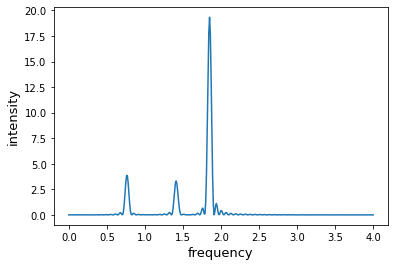

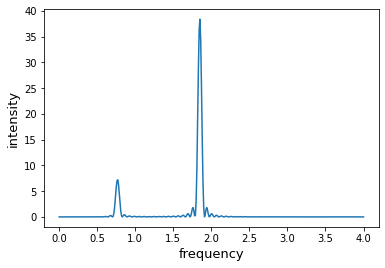

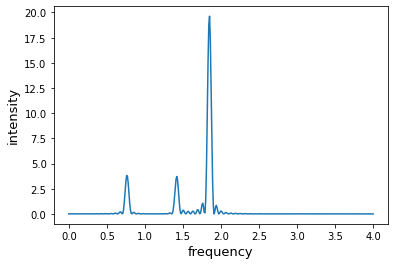

In [17]:
plt.xlabel('frequency')
plt.ylabel('intensity')
plt.plot(ft[0,:,0].real,abs(ft[0,:,1])**2)
plt.show()

plt.xlabel('frequency')
plt.ylabel('intensity')
plt.plot(ft[1,:,0].real,abs(ft[1,:,1])**2)
plt.show()

plt.xlabel('frequency')
plt.ylabel('intensity')
plt.plot(ft[2,:,0].real,abs(ft[2,:,1])**2)
plt.show()

In [18]:
#anlaytical:
omega1=np.sqrt(3.41421356* k/m)
omega2=np.sqrt(2* k/m)
omega3=np.sqrt(0.58578644* k/m)

#They crrospond to the peaks detected by our fourier transform
print(omega1)
print(omega2)
print(omega3)

#and as we can see in the second oscillator, the second frequency (1.4142)
#doesn't peak, and that's because it's component in the eigenvector is 0.

1.8477590643804185
1.4142135623730951
0.7653668662804786


## Fitting data

We consider the model function 

$$ f(t) = A_1\cos(\omega_1t+\phi_1) + A_2\cos(\omega_2t+\phi_2) + A_3\cos(\omega_3t+\phi_3)$$

The fitting parameters are

$$ \vec{a} = (A_1, \phi_1, A_2, \phi_2, A_3, \phi_3)$$



In [19]:
def modelFunction(t, a):
    return a[0]*np.cos(omega1*t+a[1]) + a[2]*np.cos(omega2*t+a[3]) + a[4]*np.cos(omega3*t+a[5])

Using the (SSE) to calculate the error: $E=\sum_{i=0}^{n} (y_{i}-f(x_{i}))^{2}$


In [20]:
def error(f,y,t,a):
  return np.sum(np.array([(y[i]-f(t[i],a))**2 for i in range(len(y))]))

By using the gradient descent method. The coefficients $a_i$ will be updated along the gradient direction of the error function 
$\nabla_{\vec{a}} \Delta$. The gradient consists of elements: $ \frac{\partial}{\partial a_k} \Delta = -2 \sum_{i=1}^n \left(y_i-f(t_i)\right) \frac{\partial}{\partial a_k}f(t_i)$

$$ \nabla_{\vec{a}} \Delta = \begin{pmatrix}
\cos(\omega_1t+\phi_1)\\
-A_1\sin(\omega_1t+\phi_1)\\
\cos(\omega_2t+\phi_2)\\
-A_2\sin(\omega_2t+\phi_2)\\
\cos(\omega_3t+\phi_3)\\
-A_3\sin(\omega_3t+\phi_3)
\end{pmatrix}$$

In [21]:
def gradiant(t,a):
    return np.array([np.cos(omega1*t + a[1]),-a[0]*np.sin(omega1*t+a[1]),
              np.cos(omega2*t + a[3]),-a[2]*np.sin(omega2*t+a[3]),
              np.cos(omega3*t + a[5]),-a[4]*np.sin(omega3*t+a[5])])

In [22]:
def gradError(f,y,t,a):
    sum=0
    for i in range(len(y)):
        sum=sum+ (y[i]-f(t[i],a))*gradiant(t[i],a)
    return -2*sum

In [23]:
iterations=20000
aTrial1=2*np.random.rand(6)-1 
aTrial2=2*np.random.rand(6)-1 
aTrial3=2*np.random.rand(6)-1 
h=0.00001 
for i in range(iterations):
    aTrial1= aTrial1-h*gradError(modelFunction,sol.y[0],sol.t,aTrial1)
    aTrial2= aTrial2-h*gradError(modelFunction,sol.y[1],sol.t,aTrial2)
    aTrial3= aTrial3-h*gradError(modelFunction,sol.y[2],sol.t,aTrial3)


* plotting 1st oscillator

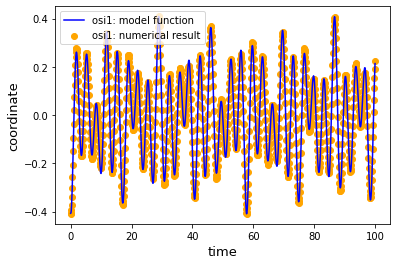

In [24]:
t_eval=np.linspace(t0,tFinal,1001)
plt.scatter(sol.t,sol.y[0],color='orange',label='osi1: numerical result')
plt.plot(t_eval,modelFunction(t_eval,aTrial1),color='blue',label='osi1: model function')
plt.ylabel('coordinate')
plt.xlabel('time')
plt.legend()

* plotting 2nd oscillator

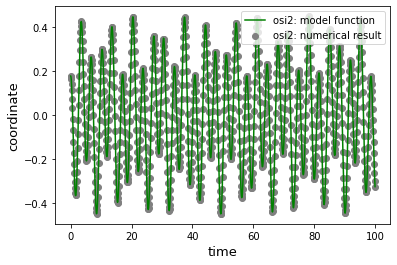

In [46]:
plt.scatter(sol.t,sol.y[1],color='grey',label='osi2: numerical result')
plt.plot(t_eval,modelFunction(t_eval,aTrial2),color='green',label='osi2: model function')
plt.ylabel('coordinate')
plt.xlabel('time')
plt.legend()


* plotting 3rd oscillator

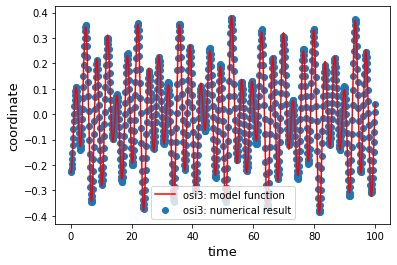

In [26]:
plt.scatter(sol.t,sol.y[2],label='osi3: numerical result')
plt.plot(t_eval,modelFunction(t_eval,aTrial3),color='red',label='osi3: model function')
plt.ylabel('coordinate')
plt.xlabel('time')
plt.legend()


# 2.Generalization to n oscillators

In [27]:
def fNOsci(t,r,n,k,m):
    coords=r[0:n]
    v=r[n:2*n]
    acc=np.zeros(n)
    # the matrix:
    #  2   -1   0  0  ....  0   0
    #  -1   2  -1  0  ....  0   0
    #   0  -1   2  -1 ....  0    0
    #         .
    #         .
    #  0   0   0   0  ....  -1  2
    
    # The middle equations have a pattern, 
    # and the first and last one can be calculated separately
    acc[0]= 2*coords[0] -coords[1]
    acc[1:-1]= -coords[:-2]+2*coords[1:-1]-coords[2:]
    acc[n-1]=-coords[n-2]+2*coords[n-1]
    return np.concatenate([v,-k/m* acc])

### Solving numerically

In [28]:
t0=0
tFinal=100
n=10 #number of oscillators.
k=1
m=1
r0=0.5 * (2*np.random.rand(2*n)-1) #random starting conditions, array of 2*n numbers between -0.5 and 0.5
solNOsci=integrate.solve_ivp(fNOsci,[t0,tFinal],r0,method='RK45',t_eval=np.linspace(t0,tFinal,1001),args=(n,k,m))

Text(0.5, 0, 'time')

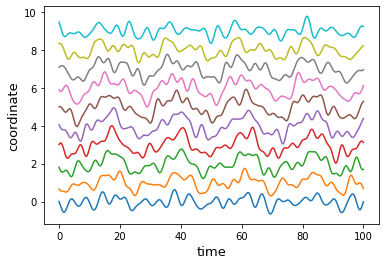

In [29]:
for i in range(n):
    plt.plot(solNOsci.t,solNOsci.y[i]+i)
plt.ylabel('coordinate')
plt.xlabel('time')
# the +i is to shift each of the oscillations up, so that all the oscillations
# can fit in one plot
#it will be tedious to make 10 plots(or sub-plots)

### Calculating the eigenfrequencies

In [30]:
#Instead of writing down a 10*10 matrix, which will be something too tedious, 
# we can benefit from the fact that the diagonals' numbers keep repeating
AnOsc=np.diag([-1]*(n-1),k=1)+np.diag([2]*(n),k=0)+np.diag([-1]*(n-1),k=-1)

In [31]:
omegas=np.sqrt(np.linalg.eigvals(AnOsc) *k/m)
omegas

array([1.97964288, 1.91898595, 1.81926399, 1.68250707, 1.51149915,
       1.30972147, 0.28462968, 0.56346511, 0.83083003, 1.08128163])

### Fourier transform

In [32]:
n=10
data=np.array([[solNOsci.t,solNOsci.y[i]] for i in range(n)])
ftNOsci=fourierTransform(data,2,n)

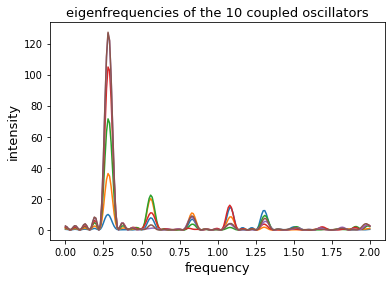

In [47]:
plt.xlabel('frequency')
plt.ylabel('intensity')
plt.title("eigenfrequencies of the 10 coupled oscillators")
for i in range(n):
    plt.plot(ftNOsci[i,:,0].real,abs(ftNOsci[i,:,1])**2)

# 3.Periodic boundary conditions

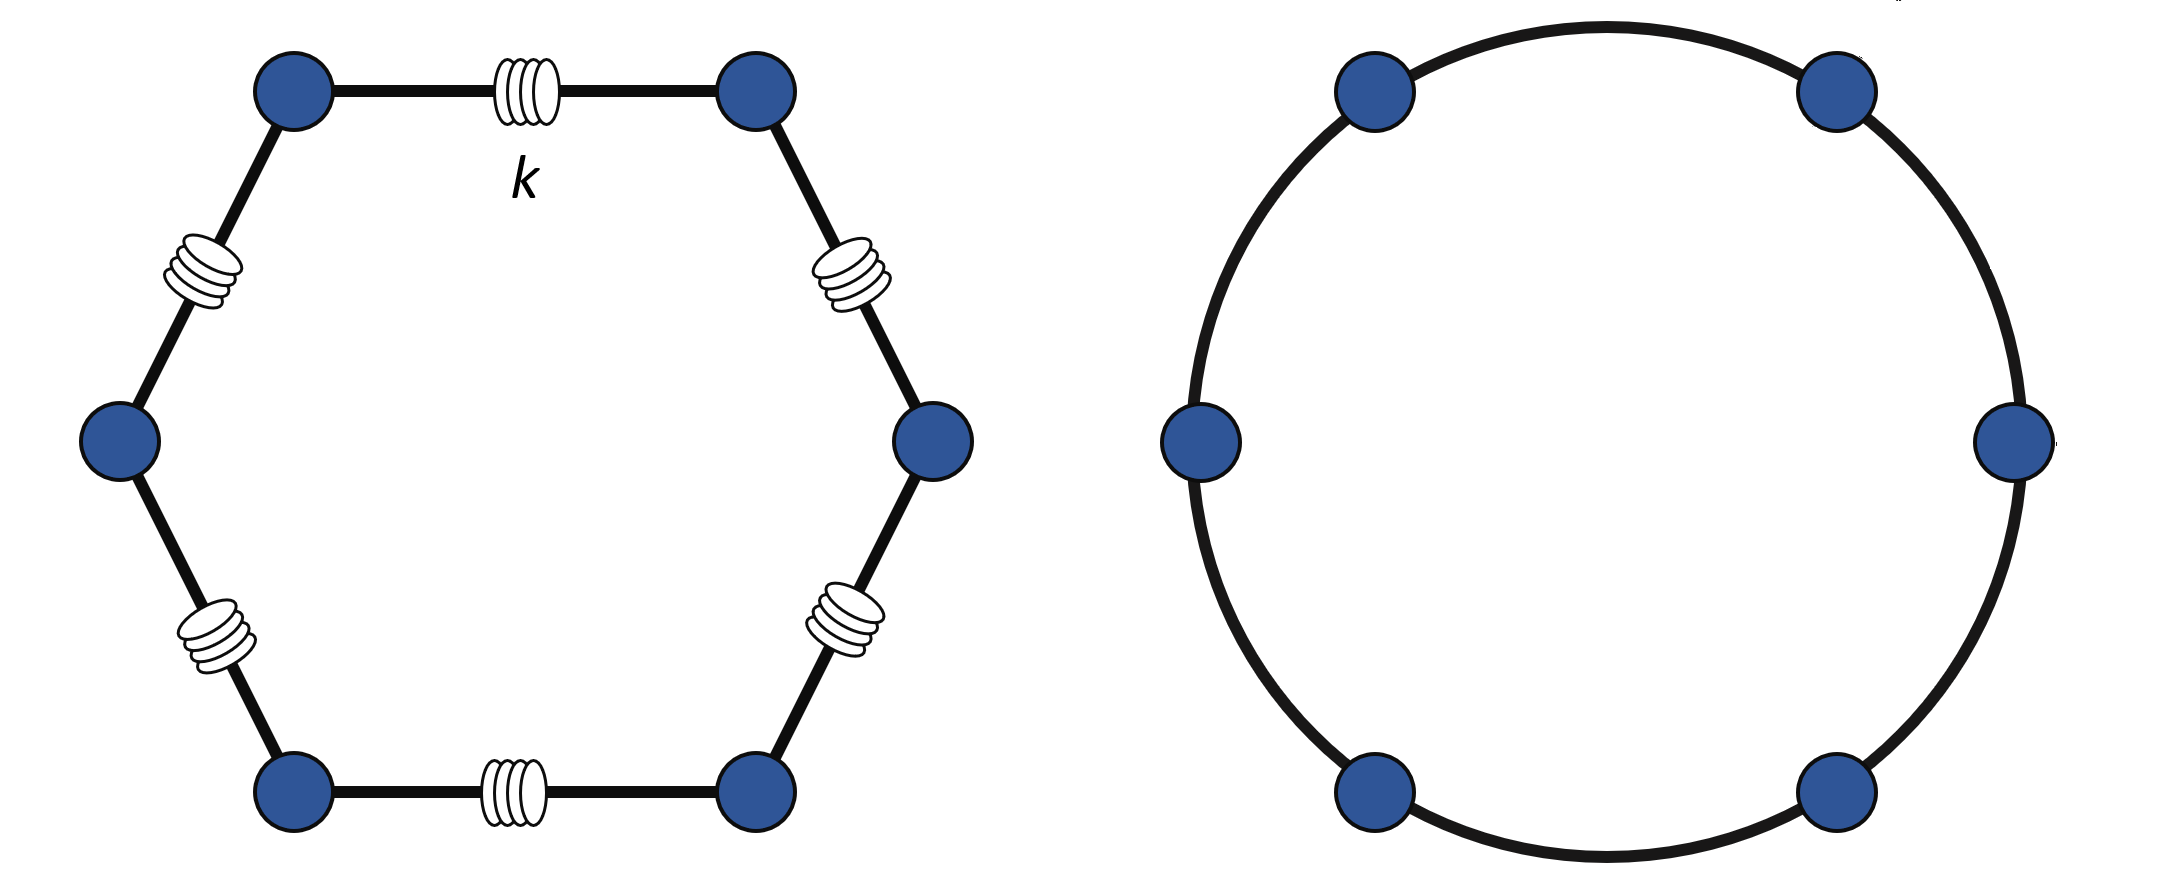

In [34]:
from PIL import Image
Image.open(r'./images/coupledOsc2.png')

The only difference is that now the first oscillator is connected to the last one, so only the first and the last equations have to be changed a little bit, to show that they are coupled.

So for example the above figures can be written as the following system of equations.
$$ 
\begin{pmatrix}\ddot{r}_1\\\ddot{r}_2\\\ddot{r}_3\\\ddot{r}_4\\\ddot{r}_5\\\ddot{r}_6\end{pmatrix}=-\frac{k}{m}
\begin{pmatrix}2&-1&0&0&0&-1\\-1&2&-1&0&0&0\\0&-1&2&-1&0&0\\0&0&-1&2&-1&0\\0&0&0&-1&2&-1\\-1&0&0&0&-1&2&\end{pmatrix}
\begin{pmatrix}r_1\\ r_2\\ r_3\\r_4\\ r_5\\ r_6\end{pmatrix}
$$

## Solving numerically 

In [35]:
def fPeriodic(t,r,n,k,m):
    coords=r[0:n]
    v=r[n:2*n]
    acc=np.zeros(n)
    acc[0]= 2*coords[0] -coords[1] -coords[n-1]
    acc[1:-1]= -coords[:-2]+2*coords[1:-1]-coords[2:]
    acc[n-1]=-coords[n-2]+2*coords[n-1] -coords[0]
    return np.concatenate([v,-k/m* acc])

In [36]:
t0=0
tFinal=100
n=6 #number of oscillators.
k=1
m=1
r0=0.5 * (2*np.random.rand(2*n)-1) #random starting conditions, array of 2*n numbers between -0.5 and 0.5
solPeriodic=integrate.solve_ivp(fPeriodic,[t0,tFinal],r0,method='RK45',t_eval=np.linspace(t0,tFinal,1001),args=(n,k,m))

Text(0.5, 0, 'time')

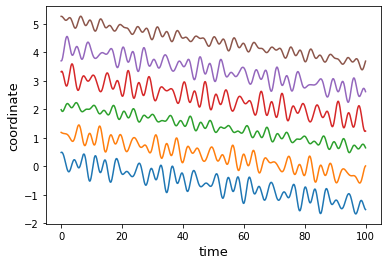

In [37]:
for i in range(n):
    plt.plot(solPeriodic.t,solPeriodic.y[i]+i)
plt.ylabel('coordinate')
plt.xlabel('time')
#we can see that the oscillations are experiencing a drift, and that's
#because the oscillators aren't fixed.

## Calculating eignefrequencies

In [38]:
APeriodic=np.diag([-1]*(n-1),k=1)+np.diag([2]*(n),k=0)+np.diag([-1]*(n-1),k=-1)
#we just have to change the last and first elements, in the first and last equations respectively.
APeriodic[0,-1]=-1
APeriodic[-1,0]=-1
eigPeriodic=np.linalg.eigvals(APeriodic)
eigPeriodic

#the first element is zero, as the corresponding mode is the translation that is allowed 
# becuase the periodic system has no fixed edges. 
# and it was forbidden before, since the system had fixed edges.
# Due to numerial errors the first element is shown as -1*10^(-16)
#which wouldn't have been a problem usually, but since we need the square root of 
# the eigvalues, we need to fix it.

array([-1.11022302e-16,  1.00000000e+00,  4.00000000e+00,  3.00000000e+00,
        1.00000000e+00,  3.00000000e+00])

In [39]:
eigPeriodic[0]=0
omegaPeriodic=np.sqrt(eigPeriodic *k/m)
omegaPeriodic

array([0.        , 1.        , 2.        , 1.73205081, 1.        ,
       1.73205081])

## Fourier transform

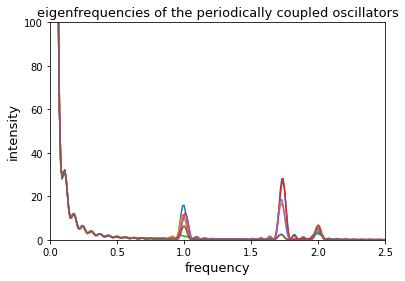

In [40]:
n=6
data=np.array([[solPeriodic.t,solPeriodic.y[i]] for i in range(n)])
ftPeriodic=fourierTransform(data,4,n)
plt.xlabel('frequency')
plt.ylabel('intensity')
plt.ylim([0,100])
plt.xlim(0,2.5)
plt.title("eigenfrequencies of the periodically coupled oscillators")
for i in range(n):
    plt.plot(ftPeriodic[i,:,0].real,abs(ftPeriodic[i,:,1])**2)
#we can see that the peaks are approximately the same as the eigenfrequencies